# 数据读入模块

In [195]:
import pandas as pd


train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [196]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [197]:
train_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial'] = [0 if pd.isna(
    i) else 1 for i in test_data['judicial_reason']]


In [198]:
train_data['nan_num'] = (train_data == 0).astype(int).sum(axis=1)
test_data['nan_num'] = (test_data == 0).astype(int).sum(axis=1)


In [199]:
import pandas as pd
temp_df = pd.read_csv("./data/detail/df_loan1_b1.csv")


def chuli_loan(df, colname, ways):
    cust_id = list(set(df['cust_id']))
    res_df = pd.DataFrame({'cust_id': cust_id})
    temp_train = pd.read_csv('./data/df_train.csv')
    temp_test = pd.read_csv('./data/df_test.csv')

    ways_1 = []
    temp = list(temp_test.columns)
    global train_data, test_data

    for i in ways:
        if (colname+'_'+i) not in temp:
            ways_1.append(i)
            res_df[colname+'_'+i] = None
        else:
            print(colname+'_'+i+'已存在')
            train_data = pd.merge(train_data, temp_train[['cust_id', colname+'_'+i]], on="cust_id",
                                  how="left", suffixes=("", "_y"))
            test_data = pd.merge(test_data, temp_test[['cust_id', colname+'_'+i]], on="cust_id",
                                 how="left", suffixes=("", "_y"))
    ways = ways_1
    if len(ways) == 0:
        return res_df
    for i in cust_id:
        cust_df = df[df['cust_id'] == i]
        if 'mean' in ways:
            x = cust_df[colname].mean()
            res_df.loc[i, colname+'_mean'] = x
        if 'sum' in ways:
            x = cust_df[colname].sum()
            res_df.loc[i, colname+'_sum'] = x
        if 'count' in ways:
            x = cust_df[colname].count()
            res_df.loc[i, colname+'_count'] = x
    return res_df


for colname in ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']:
    df = chuli_loan(temp_df, colname, ('mean', 'sum', 'count'))
    train_data = pd.merge(train_data, df, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, df, on="cust_id",
                         how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'date_3', ('count',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_10', ('mean',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_11', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))

df = chuli_loan(temp_df, 'loan1_12', ('sum',))
train_data = pd.merge(train_data, df, on="cust_id",
                      how="left", suffixes=("", "_y"))
test_data = pd.merge(test_data, df, on="cust_id",
                     how="left", suffixes=("", "_y"))


loan1_1_mean已存在
loan1_1_sum已存在
loan1_1_count已存在
loan1_3_mean已存在
loan1_3_sum已存在
loan1_3_count已存在
loan1_7_mean已存在
loan1_7_sum已存在
loan1_7_count已存在
loan1_9_mean已存在
loan1_9_sum已存在
loan1_9_count已存在
date_3_count已存在
loan1_10_mean已存在
loan1_11_sum已存在
loan1_12_sum已存在


## 处理NAN

In [200]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [201]:
df_train = delnan(train_data)
df_test = delnan(test_data)


## 处理-99

In [202]:
df_train.replace(-99, -1, inplace=True)
df_test.replace(-99, -1, inplace=True)


In [203]:
df_train.to_csv('./data/df_train.csv')
df_test.to_csv('./data/df_test.csv')


## 主成分分析（效果不好）

In [204]:
# from sklearn.decomposition import PCA

# full_col_name = list(df_train.columns)
# pca_col=[i for i in full_col_name if "loan" in i]

# modelPCA=PCA(n_components=0.9)
# temp=modelPCA.fit_transform(df_train[pca_col])
# temp1=modelPCA.transform(df_test[pca_col])
# for i in range(temp.shape[1]):
#     df_train['loan_pca'+str(i)]=temp[:,i]
#     df_test['loan_pca'+str(i)]=temp1[:,i]


## 处理分类变量

In [205]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25", ]


## 转化为one-hot编码（不宜采用）

In [206]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """


' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [207]:
import pandas as pd
import numpy as np


def cal_woe(df, df_no_label, x_cols, y_col):
    for i in x_cols:
        x_set = pd.unique(df[i])
        for j in x_set:
            woe = np.mean(df[df[i] == j][y_col])
            df[i].replace(j, woe, inplace=True)
            df_no_label[i].replace(j, woe, inplace=True)
    return df, df_no_label


In [208]:
df_train, df_test = cal_woe(df_train, df_test, type_col, "label")


In [209]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col = [i for i in full_col_name if "judicial" in i]
loan_pca_col = [i for i in full_col_name if "loan_pca" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """


' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## rank化

In [210]:
def rank(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = np.argsort(df[i])
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# rank(c)


## 归一化

In [211]:
def norm(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.min(df[i]))/(np.max(df[i])-np.min(df[i]))
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# norm(c)


## 标准化

In [212]:
def stand(rank_col):
    global df_train, df_test
    df1 = df_train[['cust_id']+rank_col]
    df2 = df_test[['cust_id']+rank_col]
    df = pd.concat([df1, df2], axis=0, ignore_index=True)
    for i in rank_col:
        df[i] = (df[i]-np.mean(df[i], axis=0))/np.std(df[i], axis=0)
        del df_test[i]
        del df_train[i]
    df_train = pd.merge(df_train, df, on="cust_id",
                        how="left", suffixes=("", "_y"))
    df_test = pd.merge(df_test, df, on="cust_id",
                       how="left", suffixes=("", "_y"))


a = ['loan1_1', 'loan1_3', 'loan1_7', 'loan1_9']
b = ['_sum', '_mean']
c = []
for i in a:
    for j in b:
        c.append(i+j)
# stand(c)


## 设置哪些x作为模型自变量输入

In [213]:
x_col = basic_col+['is_judicial']+loan_col+['date_3_count']+query_col


In [214]:
# df_train.drop(columns=drop_col)


# 训练模型

## 超参数

In [215]:
N = 1000
num_round = 100
local_test_size = 3000

max_depth = [3, 4, 5, 6, 7, 8]
eta = [0.1, 0.06]
colsample_bytree = [0.8, 0.7, 0.6]
scale_pos_weight = [1, 3, 6, 10, 20, 30]
test_size = [0.3, 0.2, 0.4, 0.5, 0.6, 0.7]
subsample = [0.8, 0.7, 0.6, 0.5, 0.4]
par_lambda = [1, 1.5, 2, 3]
alpha = [0, 0.2, 0.4, 0.6, 0.8]
min_child_weight = [1, 2, 3, 4, 5]
gamma = [0,0.1,0.2,0.3,0.4,0.5]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [216]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag = 0
important_x_seq = []

num_seq = list(range(len(df_train)))
np.random.shuffle(num_seq)

d_full=xgb.DMatrix(df_train[x_col],label=df_train['label'])

X_local_test = df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test = df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest = xgb.DMatrix(X_local_test, label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

In [217]:
for i in range(N):

    #seed = 666
    test_size_this_round = random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        # 'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample': random.choice(subsample),
        'alpha': random.choice(alpha),
        'lambda': random.choice(par_lambda),
        'min_child_weight': random.choice(min_child_weight),
        'gamma': random.choice(gamma),
        # 'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        # "enable_enable_categorical":True,
    }

    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=10, verbose_eval=False)

    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])
    global_auc=float(bst.eval(d_full).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])

    temp_dict = {"test_auc": loss, "train_auc": train_loss,
                 'local_test_auc': local_test_loss, 'test_size': test_size_this_round,
                 'global_auc':global_auc}
    temp_dict.update(param)

    # info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag == 0:
        info_df = pd.DataFrame(temp_dict, index=[i])
        flag = 1
    else:
        info_df = pd.concat([info_df, pd.DataFrame(temp_dict, index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss

    if False:
        pic = xgb.plot_importance(bst, max_num_features=50)
        temp = pic.get_ymajorticklabels()
        important_x = [str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq += important_x

    print(i+1, ":", loss, sep="")
    # print(param)
    # print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")


1:0.6949587739543536
2:0.7010633581515432
3:0.6948361606968223
4:0.6540356360470676
5:0.6978290710328453
6:0.6661986987651698
7:0.7185027100502392
8:0.6644212006427915
9:0.6575307150072661
10:0.6885761019283747
11:0.6533761406204704
12:0.6493980938365531
13:0.6801537938506919
14:0.7072498441033975
15:0.6770566734571579
16:0.5
17:0.6543238053763015
18:0.7435792329138724
19:0.6875274369439265
20:0.7363723715126718
21:0.6816874046856181
22:0.6833038167963857
23:0.7002733596328123
24:0.6797631611169093
25:0.7063390259403297
26:0.7272311518616132
27:0.6847853826994582
28:0.6635275672850797
29:0.6851681183413709
30:0.6561447658473946
31:0.6794771390310392
32:0.7078936600518295
33:0.666545714391774
34:0.6813505203405865
35:0.6959308908015741
36:0.7071872686898594
37:0.6962684815515918
38:0.7323224900385394
39:0.672569271558126
40:0.6685805929722732
41:0.6718727865136704
42:0.6693613026819923
43:0.6985978060835868
44:0.6581879884090183
45:0.6646559932701104
46:0.6558133621373509
47:0.682608620

In [218]:
info_df


,test_auc,train_auc,local_test_auc,test_size,global_auc,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,gamma,tree_method,gpu_id
0,0.694959,0.990538,0.681917,0.6,0.789655,5,0.10,0.8,binary:logistic,1,auc,0.7,0.8,3.0,2,0.1,gpu_hist,0
1,0.701063,0.975708,0.694441,0.2,0.883610,6,0.10,0.6,binary:logistic,6,auc,0.4,0.4,2.0,4,0.0,gpu_hist,0
2,0.694836,0.999976,0.693448,0.5,0.827172,8,0.10,0.7,binary:logistic,3,auc,0.8,0.6,3.0,3,0.0,gpu_hist,0
3,0.654036,0.989741,0.695172,0.7,0.755711,5,0.10,0.8,binary:logistic,6,auc,0.4,0.2,2.0,4,0.3,gpu_hist,0
4,0.697829,0.999230,0.692531,0.2,0.898559,8,0.06,0.8,binary:logistic,20,auc,0.7,0.2,1.5,2,0.3,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.681114,0.999319,0.660528,0.6,0.791683,6,0.10,0.8,binary:logistic,20,auc,0.8,0.4,3.0,2,0.2,gpu_hist,0
996,0.698027,0.911359,0.717886,0.4,0.809443,6,0.06,0.6,binary:logistic,1,auc,0.4,0.2,1.5,5,0.4,gpu_hist,0
997,0.655912,0.975079,0.672691,0.5,0.796675,5,0.10,0.6,binary:logistic,10,auc,0.6,0.8,2.0,5,0.3,gpu_hist,0
998,0.699962,0.918525,0.680679,0.3,0.826089,7,0.06,0.6,binary:logistic,1,auc,0.7,0.0,1.0,3,0.1,gpu_hist,0


In [219]:
info_df.to_csv("info.csv", encoding="utf-8", index=False)


In [220]:
# pic = xgb.plot_importance(best_bst, max_num_features=50)
# temp = pic.get_ymajorticklabels()
# important_x = [str(i).split("\'")[1] for i in temp]
# important_x.reverse()


In [221]:
# important_x


In [222]:
# pd.value_counts(important_x_seq)


* basic_7:年龄
* 

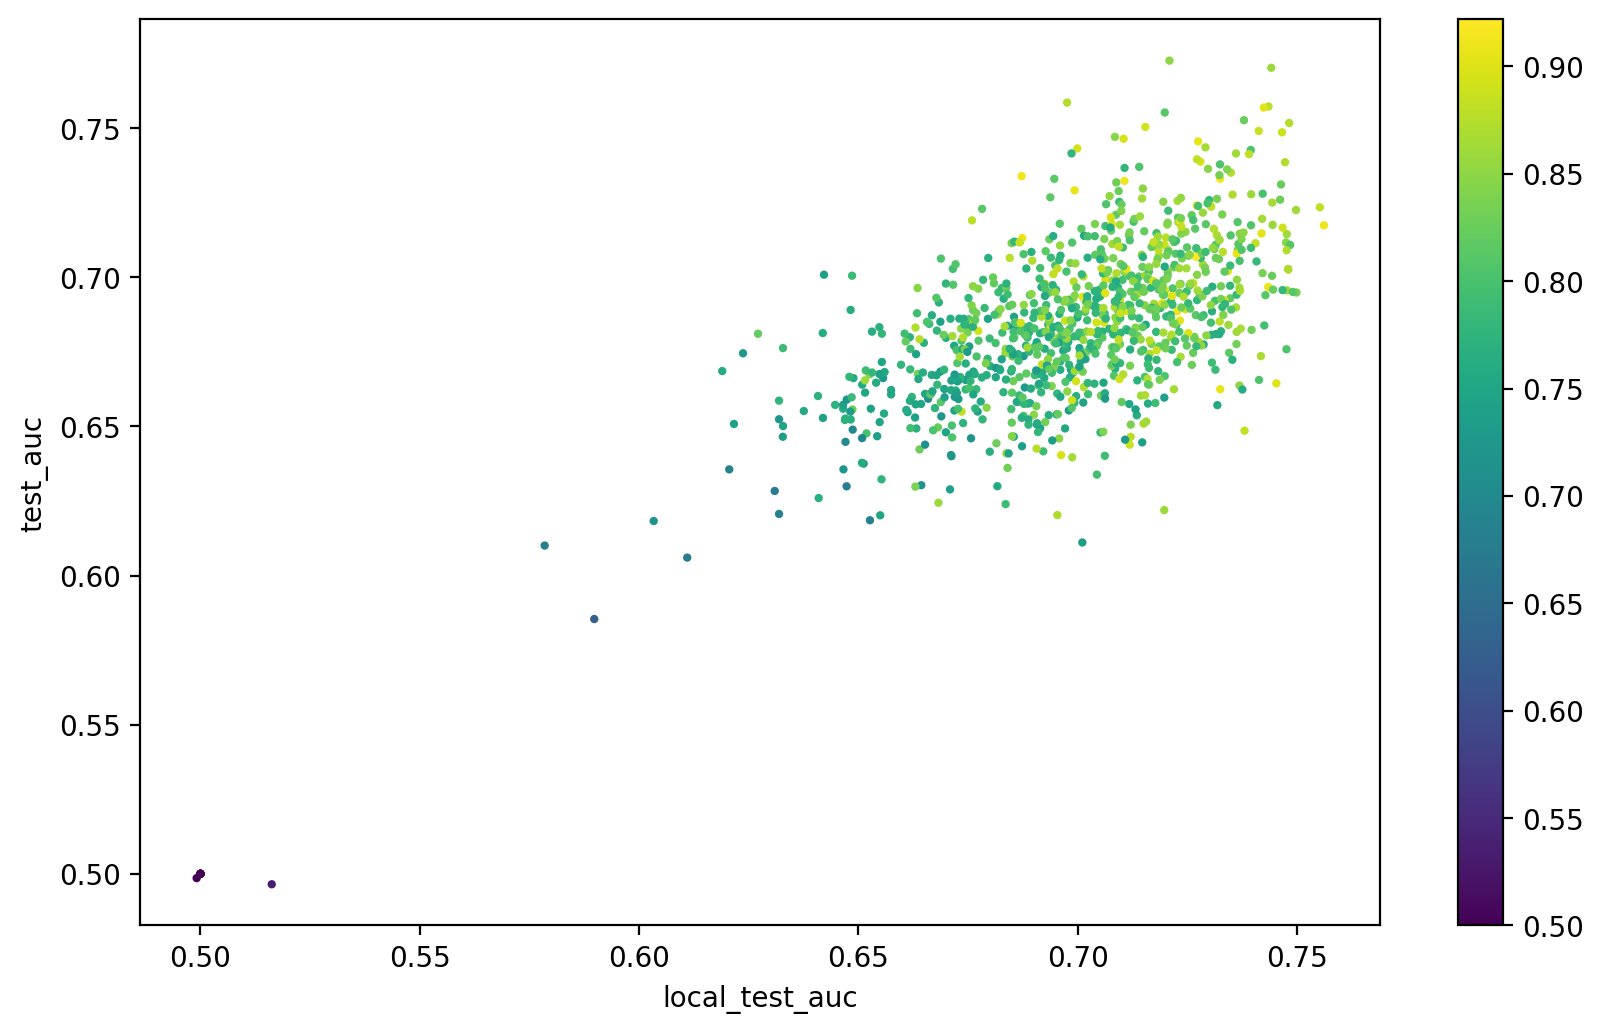

In [223]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6),dpi=200)
plt.scatter(info_df['local_test_auc'], info_df['test_auc'],c=info_df['global_auc'],s=4)
plt.xlabel('local_test_auc')
plt.ylabel('test_auc')
plt.colorbar()

# 输出模块

In [226]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if True:
    max_auc = -1
    list_temp = []
    auc_seq=[]
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        # 算数平均
        # temp = np.mean(list_temp, axis=0)
        # 几何平均(better)
        temp = np.exp(np.mean(np.log(list_temp), axis=0))
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        auc_seq.append(temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i+1
else:
    n = 40
    n = min(N, n)

res_num = res_num[0:n]

#final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
final_pred_label = np.exp(
    np.mean(np.log([pred_labels[i] for i in res_num]), axis=0))
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [
      list(info_df['local_test_auc'])[i] for i in res_num], sep="")
print("平均之后local_test_AUC为", max_auc, sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前40个auc为[0.7209034482758621, 0.7441068965517241, 0.6975724137931034, 0.7434793103448276, 0.7424068965517241, 0.7198344827586207, 0.7378896551724138, 0.7481931034482758, 0.7154068965517242, 0.7412517241379311, 0.7465689655172414, 0.7084689655172414, 0.710451724137931, 0.7274379310344827, 0.7291103448275862, 0.6998931034482758, 0.7394344827586207, 0.6985793103448276, 0.7360758620689655, 0.7390344827586207, 0.7271827586206897, 0.7279655172413793, 0.7472586206896552, 0.7324137931034482, 0.7140103448275862, 0.7106672413793104, 0.7296931034482759, 0.7340551724137931, 0.7349103448275862, 0.7322862068965518, 0.6872103448275863, 0.732448275862069, 0.6946431034482758, 0.710644827586207, 0.7087827586206896, 0.7463310344827586, 0.7148379310344828, 0.6992724137931035, 0.7093172413793103, 0.7421551724137931]
平均之后local_test_AUC为0.7619586206896551


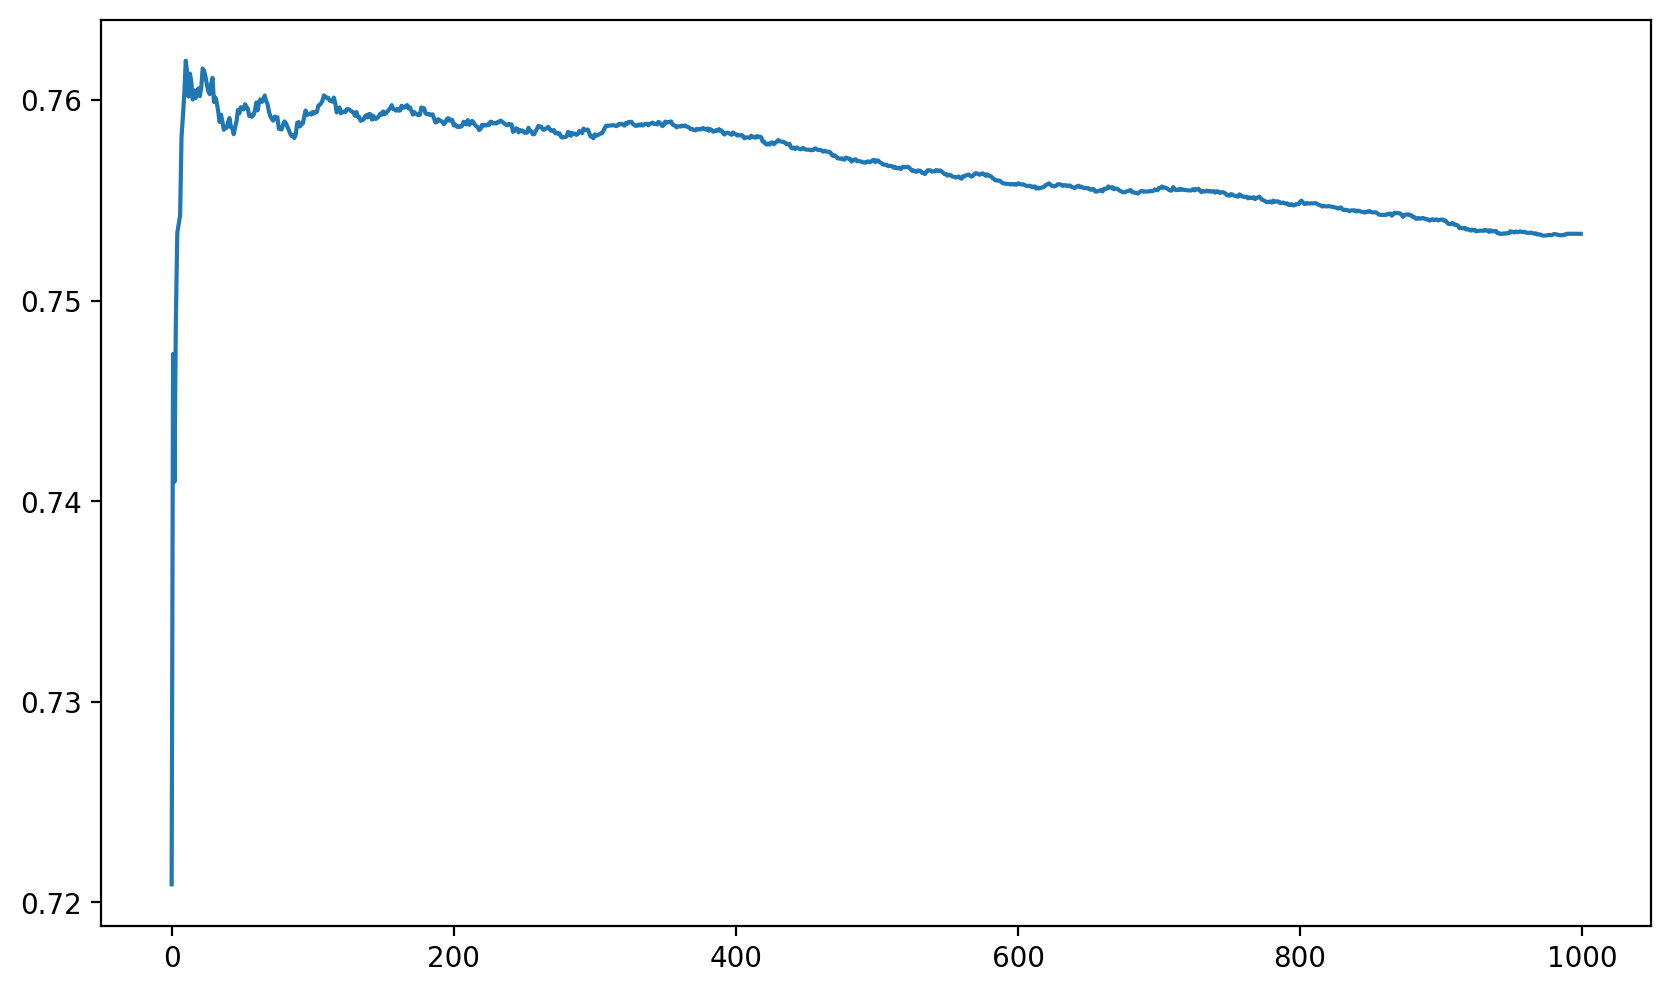

In [225]:

plt.figure(figsize=(10,6),dpi=200)
plt.plot(list(range(N)),auc_seq)

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用